## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Step 1: I'll compute the camera calibration using chessboard images

In [7]:
import cv2
import matplotlib.pyplot as plt; import matplotlib.image as mpimg
import numpy as np
import glob; import pickle; import os
%matplotlib inline

In [2]:
# dimensions of chessboard
nx, ny = 9, 6

# prepare object points (0,0,0), (1,0,0), (2,0,0) .. (8,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[:nx, :ny].T.reshape(-1,2)

# arrays to store object points and image points
objpoints = [] # 3d points in the real world
imgpoints = [] # 2d points in image space 

images = glob.glob('camera_cal/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # if found, store in objpoints and imagepoints. 
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # draw and display corners
#         img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#         cv2.imshow('img', img)
#         cv2.waitKey(500)
        
# cv2.destroyAllWindows()

## Step 2: Apply a distortion correction to raw images

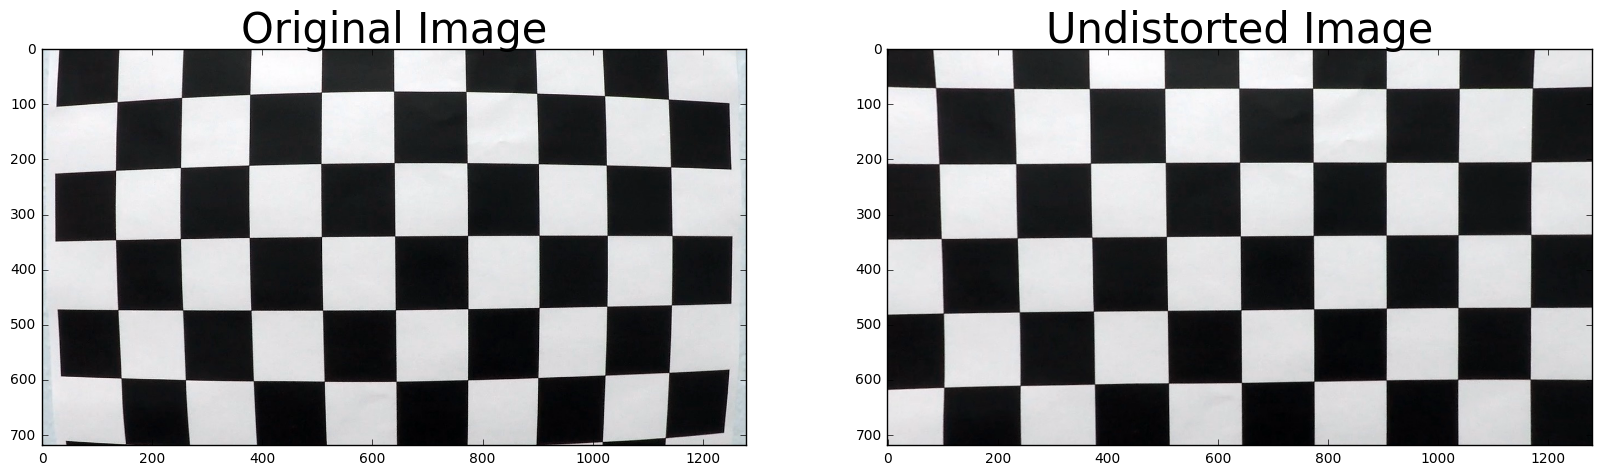

In [4]:
# select a chessboard image exmaple, undistort it
img = cv2.imread(images[0])
img_size = (img.shape[1], img.shape[0])

# compute camera calibration matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/camera_cal_check.jpg', dst)

# plot the example before and after calibration
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize = 30)                                                 

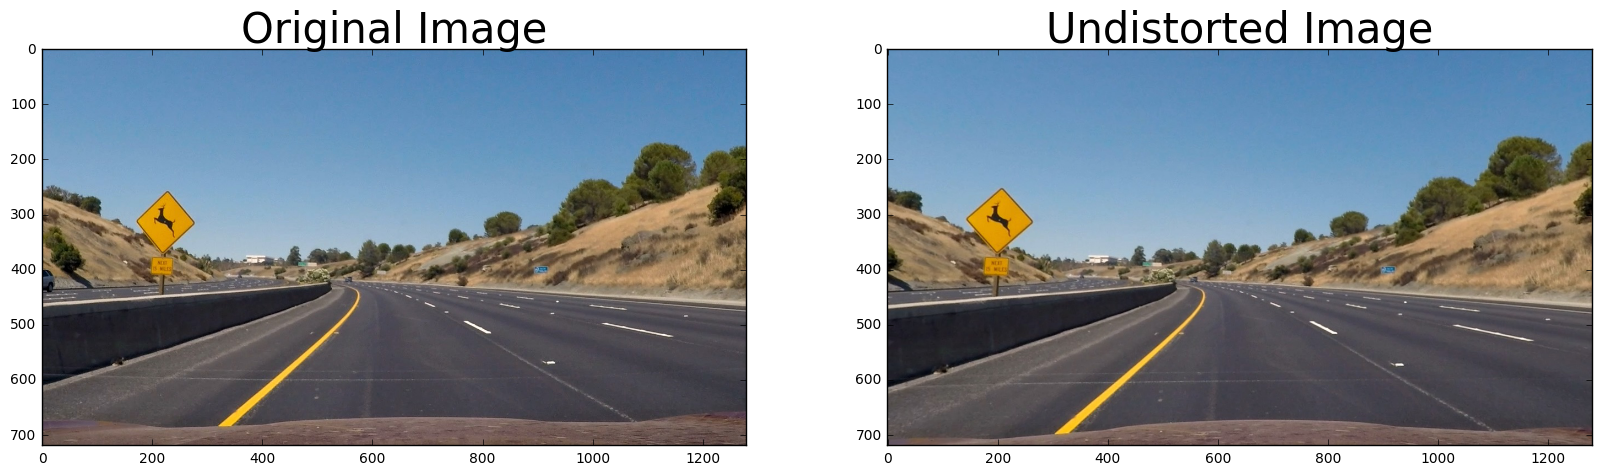

In [5]:
# select a lane example, undistort it
lane_img = cv2.imread('test_images/test2.jpg')
lane_img_size = (lane_img.shape[1], lane_img.shape[0])
lane_dst = cv2.undistort(lane_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize = 30)
ax2.imshow(cv2.cvtColor(lane_dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize = 30)

In [8]:
# save camera calibration matrix and distortion coefficients
myCalibration = {'mtx': mtx, 'dist': dist}

if not os.path.exists('./output'):
    os.makedirs('./output')

pickle.dump(myCalibration, open("./output/myCalibration.p", "wb"))

myCalibration = pickle.load(open("./output/myCalibration.p", "rb"))

In [9]:
import pickle
myCalibration = pickle.load(open("./output/myCalibration.p", "rb"))

## Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.

In [10]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    '''
    "Taking the gradients in the x-direction emphasizes edges closer to vertical
    and in the y-direction, edges closer to horizontal."
    '''
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

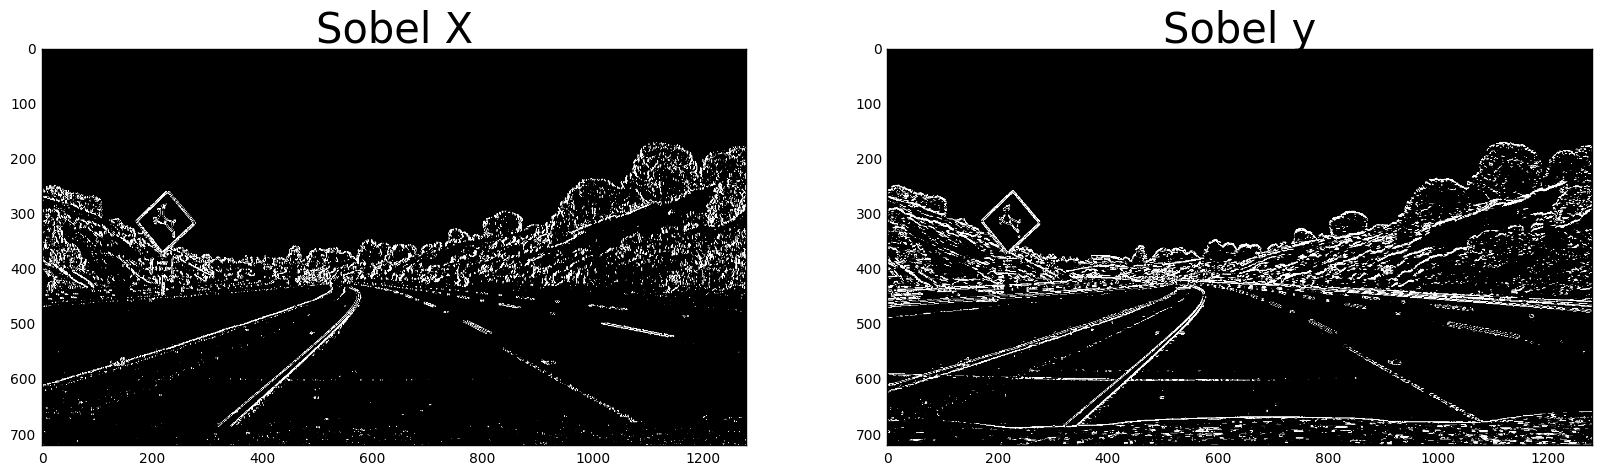

In [24]:
lane_img = mpimg.imread('test_images/test2.jpg')
lane_img_size = (lane_img.shape[1], lane_img.shape[0])
mtx = myCalibration['mtx']
dist = myCalibration['dist']
lane_dst = cv2.undistort(lane_img, mtx, dist, None, mtx)

lane_gradx = abs_sobel_thresh(lane_img, 'x', 20, 100)
lane_grady = abs_sobel_thresh(lane_img, 'y', 20, 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(lane_gradx, cmap = 'gray')
ax1.set_title('Sobel X', fontsize = 30)
ax2.imshow(lane_grady, cmap = 'gray')
ax2.set_title('Sobel y', fontsize = 30)

In [41]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 5) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 6) Create a binary mask where mag thresholds are met
    # 7) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # mag is a matrix
    mag = np.sqrt(sobelx**2+sobely**2)
    
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    
    binary_output = np.zeros_like(gray)
    binary_output[(scaled_sobel>=mag_thresh[0])&(scaled_sobel<=mag_thresh[1])] = 1
    return binary_output

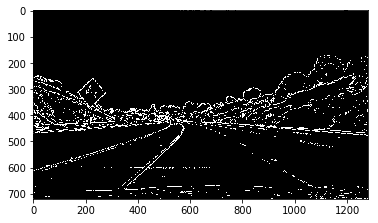

In [44]:
lane_mag_small = mag_thresh(lane_img, 1, (30, 100))

plt.imshow(lane_mag_small, cmap = 'gray')

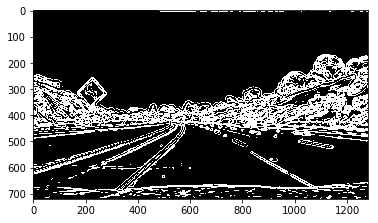

In [43]:
lane_mag_large = mag_thresh(lane_img, 29, (20, 100))
plt.imshow(lane_mag_large, cmap = 'gray')

In [45]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

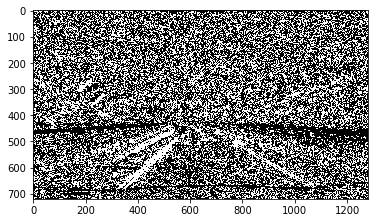

In [46]:
lane_dir = dir_threshold(lane_img, sobel_kernel=15, thresh=(0.7, 1.3))
plt.imshow(lane_dir, cmap = 'gray')

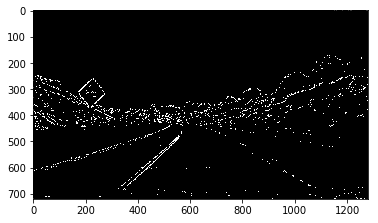

In [52]:
combined = np.zeros_like(lane_dir)
combined[((lane_gradx==1)&(lane_grady==1))|((lane_mag_small==1)&(lane_dir==1))] = 1
plt.imshow(combined, cmap = 'gray')

In [25]:
def hls_select(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_output

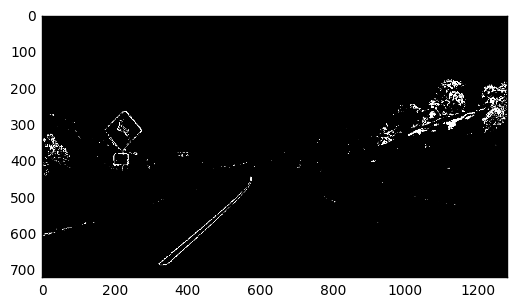

In [27]:
lane_color = hls_select(lane_img, thresh=(120,200))
plt.imshow(lane_color, cmap = 'gray')

In [ ]:
def thresholding(img, hsv_thresh=(170,255), sobel_kernal=3, 
                 gradx_thresh=(20,100), grady_thresh=(20,100), 
                 mag_thresh=(30,100), dir_thresh(.7,1.3)):
    
    return binary

In [ ]:
binary = thresholding(lane_img)
plt.imshow(binary, cmap = 'gray')

## Step 4: Apply a perspective transform to rectify binary image ("birds-eye view")

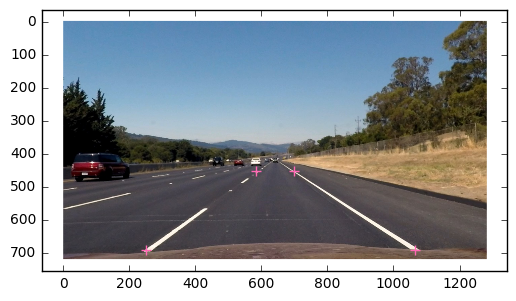

In [182]:
lane_img = mpimg.imread('test_images/straight_lines2.jpg')
lane_img_size = (lane_img.shape[1], lane_img.shape[0])
mtx = myCalibration['mtx']
dist = myCalibration['dist']
lane_dst = cv2.undistort(lane_img, mtx, dist, None, mtx)
implot = plt.imshow(lane_dst)
# plt.scatter([625,655,250,1068],[425,425,690,690], 
#             c='#FF69B4', marker='+', s=50)
plt.scatter([585,699,1065,250],[450,450,690,690], 
            c='#FF69B4', marker='+', s=50)

In [216]:
def warping(img, w=1280, h=720):
    '''
    These four points were chosen using P1 line slope math. 
    '''
    #src = np.float32([[625,425],[655,425],[1068,690],[250,690]])
    src = np.float32([[595,450],[689,450],[1060,690],[250,690]])
    dst=np.float32([[w/4,0],[w*3/4,0],[w*3/4,h],[w/4,h]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h))
    return warped, M, Minv

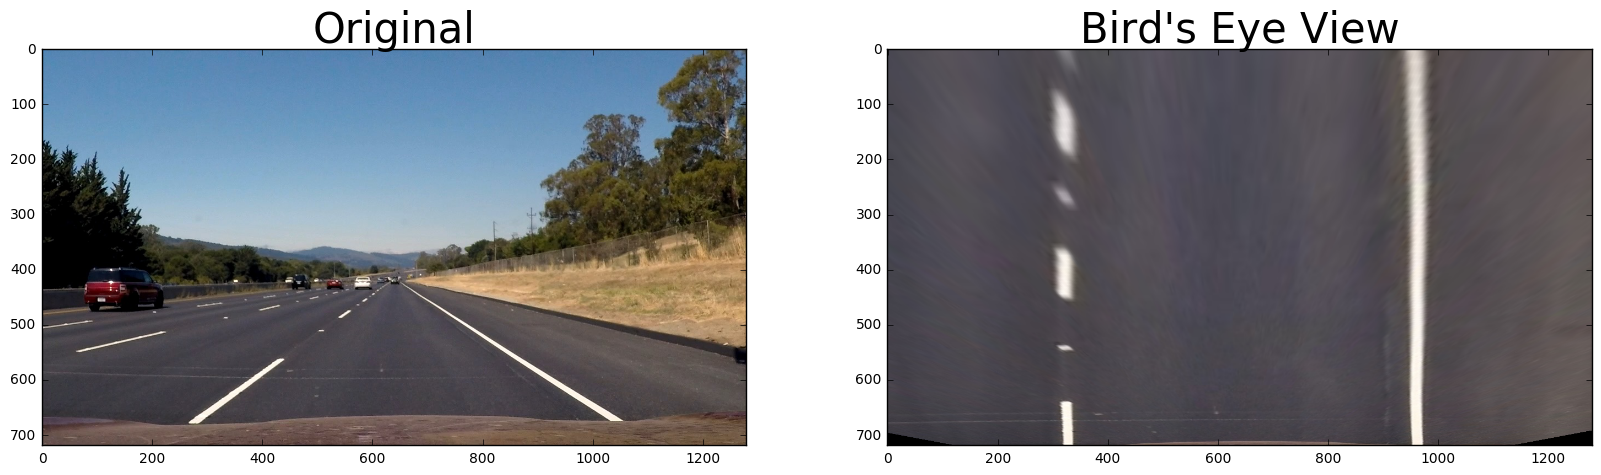

In [221]:
warped, M, Minv = warping(lane_dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(lane_img)
ax1.set_title('Original', fontsize = 30)
ax2.imshow(warped)
ax2.set_title('Bird\'s Eye View', fontsize = 30)

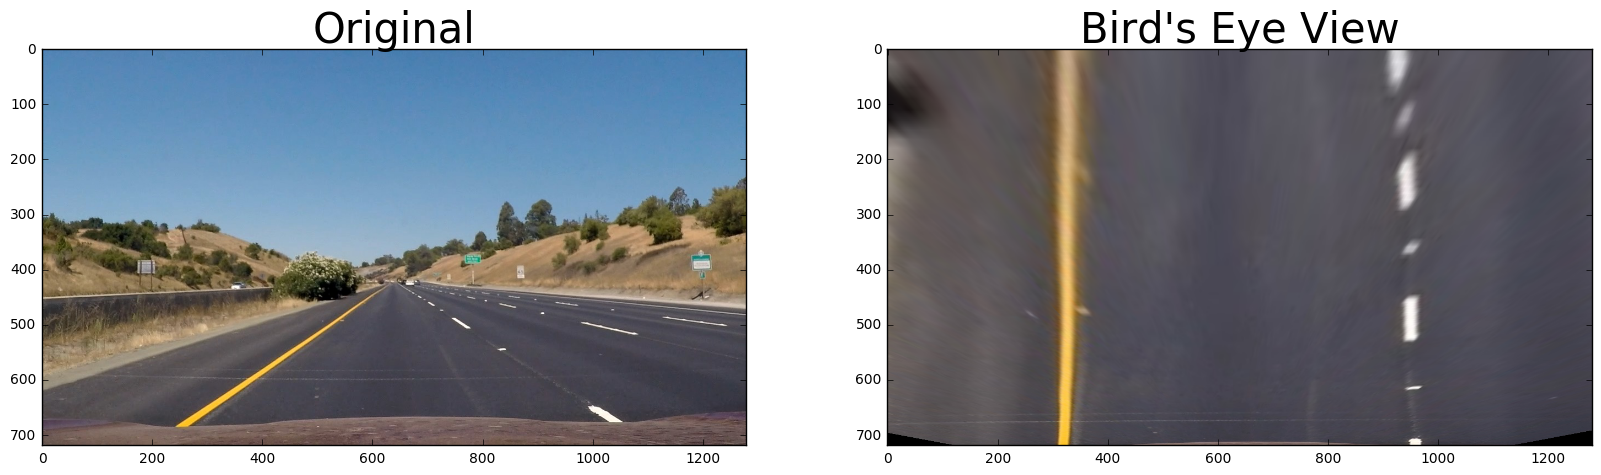

In [222]:
lane_img2 = mpimg.imread('test_images/straight_lines1.jpg')
lane_dst2 = cv2.undistort(lane_img2, mtx, dist, None, mtx)
warped2 = cv2.warpPerspective(lane_dst2, M, (1280,720))

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(lane_img2)
ax1.set_title('Original', fontsize = 30)
ax2.imshow(warped2)
ax2.set_title('Bird\'s Eye View', fontsize = 30)